In [ ]:
# === 0. Инициализация окружения ===

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from pathlib import Path

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
sns.set(style="whitegrid")

print("Готово. Версии:")
print("pandas:", pd.__version__)
print("numpy:", np.__version__)


Готово. Версии:
pandas: 2.2.2
numpy: 2.0.2


In [ ]:
# === 1. Пути и загрузка данных ===

DATA_DIR = Path("/content")

files = {
    "companies": "companies.csv",
    "revenue": "revenue.csv",
    "ltv": "ltv.csv",
    "rfm": "rfm.csv",
    "basket": "basket.csv",
    "rfm_features": "rfm-features.csv",
}

dfs = {}

for name, fname in files.items():
    path = DATA_DIR / fname
    if path.exists():
        print(f"Загружаю {name} из {path}")
        if name == "revenue":
            df = pd.read_csv(path)
            if "sale_date" in df.columns:
                df["sale_date"] = pd.to_datetime(df["sale_date"])
        elif name in ["ltv", "rfm"]:
            df = pd.read_csv(path)
            for col in ["first_purchase", "last_purchase"]:
                if col in df.columns:
                    df[col] = pd.to_datetime(df[col])
        else:
            df = pd.read_csv(path)
        dfs[name] = df
    else:
        print(f"⚠️ Файл не найден: {path} — пропускаю.")

print("\nЗагружены датасеты:")
print(list(dfs.keys()))


Загружаю companies из /content/companies.csv
Загружаю revenue из /content/revenue.csv
Загружаю ltv из /content/ltv.csv
Загружаю rfm из /content/rfm.csv
Загружаю basket из /content/basket.csv
Загружаю rfm_features из /content/rfm-features.csv

Загружены датасеты:
['companies', 'revenue', 'ltv', 'rfm', 'basket', 'rfm_features']


In [ ]:
# === 2. Вспомогательные функции ===

def quick_overview(df: pd.DataFrame, name: str, n_head: int = 5):
    print(f"\n{'=' * 40}\nОбщий обзор: {name}\n{'=' * 40}")
    print("\nРазмер:", df.shape)
    print("\nПервые строки:")
    display(df.head(n_head))
    print("\nТипы и количество ненулевых значений:")
    print(df.info())
    print("\nЧисловое описание:")
    display(df.describe(include="number").T)
    print("\nКатегориальное описание:")
    display(df.describe(include="object").T)

def missing_values_report(df: pd.DataFrame, name: str):
    print(f"\n--- Пропуски в {name} ---")
    miss = df.isna().sum()
    miss = miss[miss > 0].sort_values(ascending=False)
    if miss.empty:
        print("Пропусков нет.")
    else:
        report = pd.DataFrame({
            "n_missing": miss,
            "pct_missing": (miss / len(df) * 100).round(2)
        })
        display(report)

def plot_numeric_distributions(df: pd.DataFrame, cols=None, bins: int = 30, title_prefix: str = ""):
    if cols is None:
        cols = df.select_dtypes(include="number").columns
    for col in cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col].dropna(), bins=bins, kde=True)
        plt.title(f"{title_prefix}{col} — распределение")
        plt.xlabel(col)
        plt.ylabel("Количество")
        plt.show()

def top_categories(df: pd.DataFrame, col: str, top_n: int = 20):
    vc = df[col].value_counts().head(top_n)
    print(f"\nТОП-{top_n} категорий по {col}:")
    display(vc.to_frame("count"))
    plt.figure(figsize=(8, 4))
    sns.barplot(x=vc.values, y=vc.index)
    plt.title(f"ТОП-{top_n} по {col}")
    plt.xlabel("Количество")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()



Общий обзор: companies

Размер: (2120, 7)

Первые строки:


,Unnamed: 0,company_id,sector,segment,industry,company_size,revenue
0,0,comp_df0a0c0bd619,sec_07f5ebaa60c6,Public_Small_Medium,ind_d2091f85a3a3,50.0,105402
1,1,comp_1e8c0f0ab24c,sec_9d370c38febe,Small_business,ind_6be1923b9422,28.0,107905
2,2,comp_7b5d176f09b3,sec_5fb21c55bb11,Business_Scale,ind_5fb21c55bb11,5000.0,248435
3,3,comp_d07c716a7b02,sec_1bc3700e30b8,Public_Small_Medium,ind_11d103ed33f7,100.0,111632
4,4,comp_ca8821847ff0,sec_1bc3700e30b8,Public_Large,ind_5ffda163ccd7,50.0,106819



Типы и количество ненулевых значений:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2120 non-null   int64  
 1   company_id    2120 non-null   object 
 2   sector        2120 non-null   object 
 3   segment       2120 non-null   object 
 4   industry      2120 non-null   object 
 5   company_size  2101 non-null   float64
 6   revenue       2120 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 116.1+ KB
None

Числовое описание:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2120.0,1059.500000,612.135606,0.0,529.75,1059.5,1589.25,2119.0
company_size,2101.0,730.447882,1535.692779,0.0,50.00,122.0,500.00,14847.0
revenue,2120.0,153672.850000,372844.949260,100065.0,105351.50,108876.0,112875.25,10315424.0



Категориальное описание:


,count,unique,top,freq
company_id,2120,2120,comp_8ba60e372370,1
sector,2120,9,sec_9d370c38febe,364
segment,2120,10,Public_Large,541
industry,2120,35,ind_135b1d02b8a4,330



--- Пропуски в companies ---


,n_missing,pct_missing
company_size,19,0.9



Уникальных company_id: 2120, строк всего: 2120


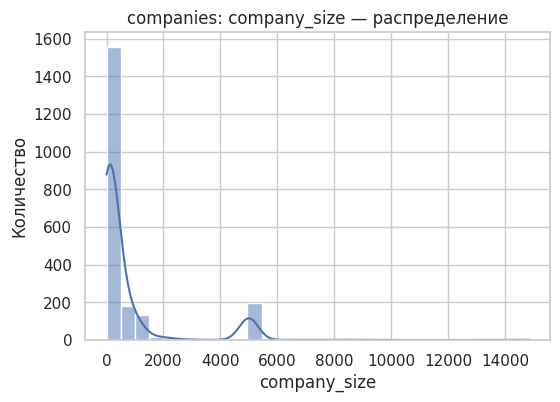

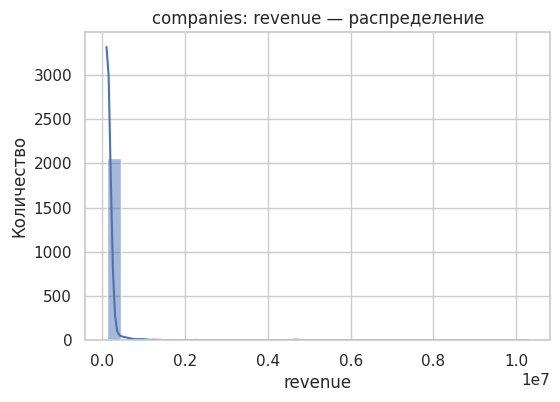


ТОП-15 категорий по segment:


,count
segment,
Public_Large,541
Small_business,483
Public_Small_Medium,304
Large_business,231
Medium_business,214
Business_Scale,134
Micro,122
Commercial_Scale,78
Undefined,8


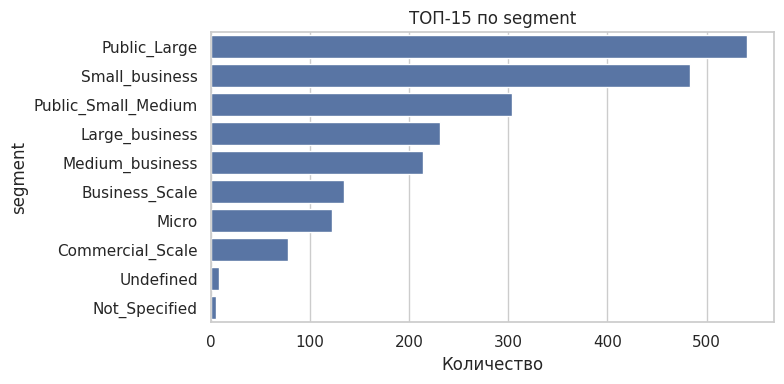


ТОП-15 категорий по industry:


,count
industry,
ind_135b1d02b8a4,330
ind_316195b443c6,271
ind_5fb21c55bb11,261
ind_f2f98412ca9a,166
ind_5ffda163ccd7,155
ind_28f0e3119b87,110
ind_c3c0ab208b3b,105
ind_17fc30c258ad,68
ind_34ea208071c4,58


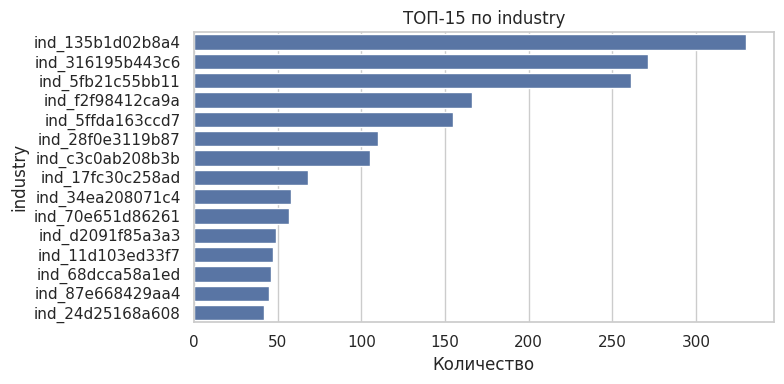

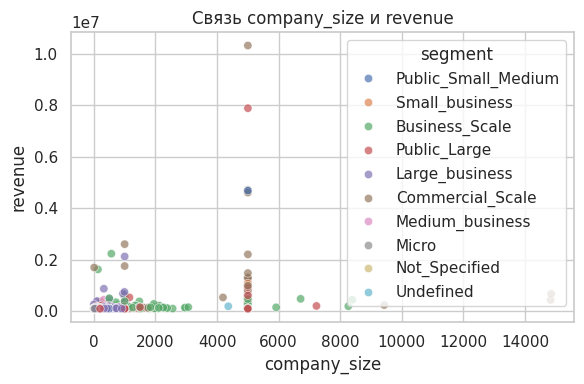


Корреляция между company_size и revenue:


,company_size,revenue
company_size,1.000000,0.251013
revenue,0.251013,1.000000


In [ ]:
# === 3. EDA: companies (клиенты) ===
if "companies" in dfs:
    companies = dfs["companies"].copy()


    import numpy as np
    for col in ["company_size", "revenue"]:
        if col in companies.columns:
            companies[col] = (
                companies[col]
                .replace(["нет данных", "НЕТ ДАННЫХ", "-", "n/a", "NA"], np.nan)
            )
            companies[col] = pd.to_numeric(companies[col], errors="coerce")


    quick_overview(companies, "companies")
    missing_values_report(companies, "companies")

    # Проверка уникальности company_id
    if "company_id" in companies.columns:
        n_unique = companies["company_id"].nunique()
        print(f"\nУникальных company_id: {n_unique}, строк всего: {len(companies)}")
        if n_unique < len(companies):
            print("⚠️ Внимание: есть дубликаты company_id!")

    # Распределения числовых признаков
    num_cols = [c for c in ["company_size", "revenue"] if c in companies.columns]
    if num_cols:
        plot_numeric_distributions(companies, num_cols, title_prefix="companies: ")

    # Категориальные признаки (если есть)
    for cat_col in ["segment", "sector_id", "industry"]:
        if cat_col in companies.columns:
            top_categories(companies, cat_col, top_n=15)

    # Связь размера компании и выручки (если есть оба столбца)
    if set(["company_size", "revenue"]).issubset(companies.columns):
        plt.figure(figsize=(6, 4))
        hue = companies["segment"] if "segment" in companies.columns else None
        sns.scatterplot(
            data=companies,
            x="company_size",
            y="revenue",
            hue=hue,
            alpha=0.7
        )
        plt.title("Связь company_size и revenue")
        plt.tight_layout()
        plt.show()

        corr = companies[["company_size", "revenue"]].corr()
        print("\nКорреляция между company_size и revenue:")
        display(corr)
else:
    print("companies.csv не загружен")



Общий обзор: revenue

Размер: (16822, 9)

Первые строки:


,Unnamed: 0,row_id,company_id,sale_id,sale_date,product_name,product_sum,sale_type,product_duration
0,0,row_8ae3f0a90135,comp_94b3dbfa3cdb,sal_117719067179,2021-02-09,Расширения,10000,Новая,1
1,1,row_e056ebe0bd07,comp_94b3dbfa3cdb,sal_8f5df72ac2f7,2023-03-17,Расширения,10000,Продление,1
2,2,row_04471fe231b0,comp_94b3dbfa3cdb,sal_117719067179,2021-02-09,Тарифы Webinar СМБ,11000,Новая,1
3,3,row_3c10791fca1f,comp_94b3dbfa3cdb,sal_8f5df72ac2f7,2023-03-17,Тарифы Webinar СМБ,11000,Продление,1
4,4,row_c25e0ba18d2e,comp_94b3dbfa3cdb,sal_fbb04b9291d4,2021-11-27,Тарифы Webinar СМБ,11000,Продление,1



Типы и количество ненулевых значений:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16822 entries, 0 to 16821
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        16822 non-null  int64         
 1   row_id            16822 non-null  object        
 2   company_id        16822 non-null  object        
 3   sale_id           16822 non-null  object        
 4   sale_date         16820 non-null  datetime64[ns]
 5   product_name      16822 non-null  object        
 6   product_sum       16822 non-null  int64         
 7   sale_type         14087 non-null  object        
 8   product_duration  16822 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 1.2+ MB
None

Числовое описание:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,16822.0,8410.500000,4856.237450,0.0,4205.25,8410.5,12615.75,16821.0
product_sum,16822.0,15147.069314,19996.721315,10000.0,10000.00,11000.0,14000.00,1000000.0
product_duration,16822.0,7.208655,6.587408,1.0,1.00,6.0,12.00,60.0



Категориальное описание:


,count,unique,top,freq
row_id,16822,16822,row_d12f5a71fbed,1
company_id,16822,2120,comp_f236f371ab19,135
sale_id,16822,11294,sal_843ac851a41f,46
product_name,16822,28,Тарифы Webinar СМБ,6512
sale_type,14087,4,Продление,8276



--- Пропуски в revenue ---


,n_missing,pct_missing
sale_type,2735,16.26
sale_date,2,0.01



Уникальных row_id: 16822, строк всего: 16822


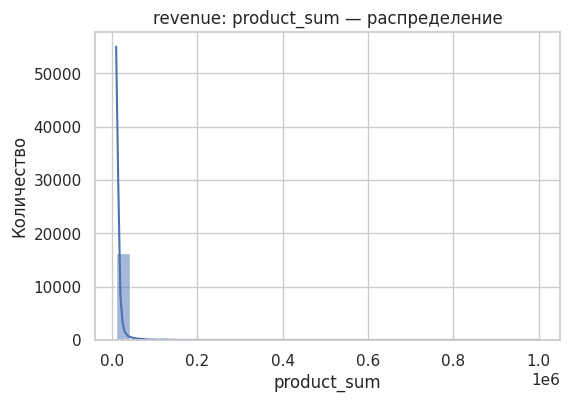

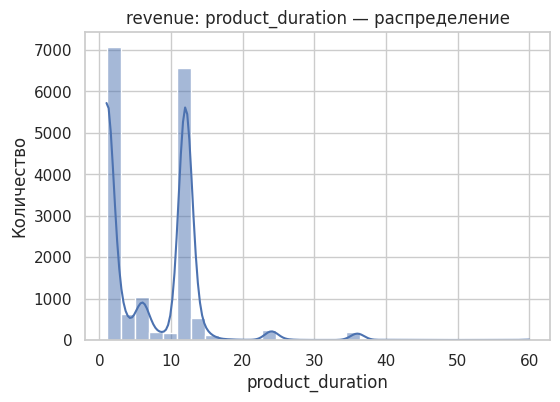


ТОП-20 категорий по product_name:


,count
product_name,
Тарифы Webinar СМБ,6512
Расширения,6485
Enterprise-100,479
Enterprise-300,470
Enterprise-150,417
Enterprise-500,375
Enterprise-50,277
Доски,196
Enterprise Total-300,191


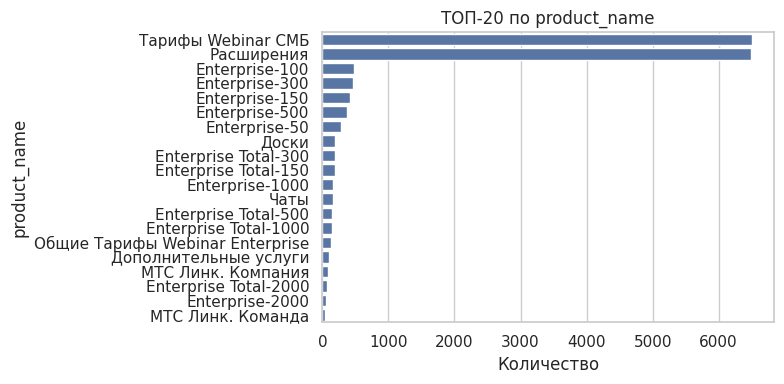


ТОП-10 категорий по sale_type:


,count
sale_type,
Продление,8276
Новая,3218
Расширение,1639
Возврат,954


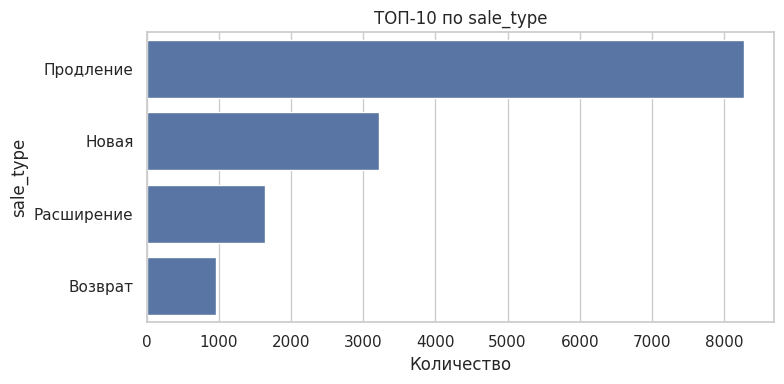


Пример агрегированных заказов:


,sale_id,n_lines,order_sum
0,sal_00071aa12c0b,1,12000
1,sal_0011814def23,1,13000
2,sal_001f1b0d6310,2,26000
3,sal_00224ee345f6,1,11000
4,sal_0022db05ad72,1,10000


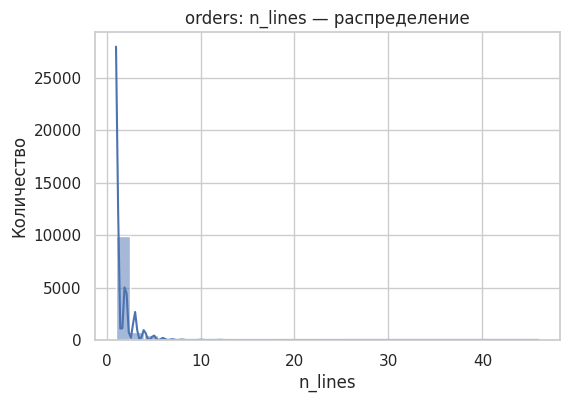

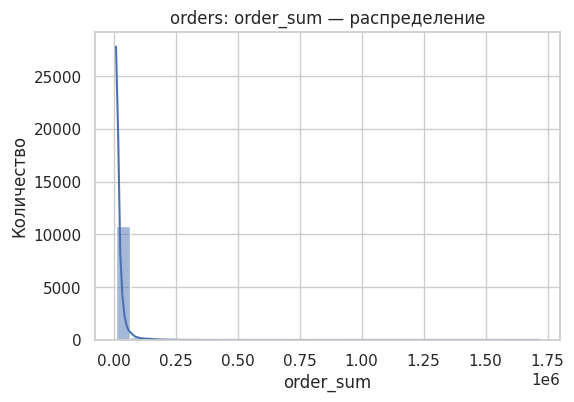


Период данных по продажам:
2014-01-22 00:00:00 → 2023-10-13 00:00:00


In [ ]:
# === 4. EDA: revenue ===

if "revenue" in dfs:
    revenue = dfs["revenue"].copy()
    quick_overview(revenue, "revenue")
    missing_values_report(revenue, "revenue")

    # Проверка уникальности row_id
    if "row_id" in revenue.columns:
        n_unique = revenue["row_id"].nunique()
        print(f"\nУникальных row_id: {n_unique}, строк всего: {len(revenue)}")
        if n_unique < len(revenue):
            print("⚠️ Есть дубликаты row_id")

    # Базовая статистика по сумме продукта и длительности
    num_cols = [c for c in ["product_sum", "product_duration"] if c in revenue.columns]
    plot_numeric_distributions(revenue, num_cols, title_prefix="revenue: ")

    # ТОП продуктов
    if "product_name" in revenue.columns:
        top_categories(revenue, "product_name", top_n=20)

    # ТОП типов сделок
    if "sale_type" in revenue.columns:
        top_categories(revenue, "sale_type", top_n=10)

    # Анализ заказов: сколько строк в заказе и сумма заказа
    if "sale_id" in revenue.columns and "product_sum" in revenue.columns:
        orders = (
            revenue
            .groupby("sale_id")
            .agg(
                n_lines=("row_id", "count") if "row_id" in revenue.columns else ("product_name", "count"),
                order_sum=("product_sum", "sum")
            )
            .reset_index()
        )
        print("\nПример агрегированных заказов:")
        display(orders.head())

        plot_numeric_distributions(orders, ["n_lines", "order_sum"], title_prefix="orders: ")

    # Временной анализ (если sale_date есть)
    if "sale_date" in revenue.columns:
        print("\nПериод данных по продажам:")
        print(revenue["sale_date"].min(), "→", revenue["sale_date"].max())

        revenue["sale_date_date"] = revenue["sale_date"].dt.date

        daily = (
            revenue
            .groupby("sale_date_date")["product_sum"]
            .sum()
            .reset_index()
            .rename(columns={"product_sum": "daily_revenue"})
        )

        fig = px.line(daily, x="sale_date_date", y="daily_revenue", title="Дневная выручка (revenue)")
        fig.show()

        # Продажи по дню недели
        revenue["sale_dayofweek"] = revenue["sale_date"].dt.dayofweek
        dow = revenue.groupby("sale_dayofweek")["product_sum"].sum().reset_index()
        fig = px.bar(dow, x="sale_dayofweek", y="product_sum", title="Выручка по дням недели (0=пн)")
        fig.show()

else:
    print("revenue.csv не загружен")



Общий обзор: ltv

Размер: (2120, 8)

Первые строки:


,company_id,first_purchase,last_purchase,ltv,customer_age_days,customer_age_years,ltv_per_year,ltv_12m
0,comp_0004b685d8d6,2019-05-03,2019-05-03,17000,1624,4.446270,3823.429803,0
1,comp_001eac7794df,2020-09-23,2023-09-03,270000,1115,3.052704,88446.188341,80000
2,comp_002f5166d79b,2020-11-28,2020-11-28,31000,1049,2.872005,10793.851287,0
3,comp_00323bea932a,2020-08-17,2020-08-17,16000,1152,3.154004,5072.916667,0
4,comp_003be29c3721,2022-09-24,2022-09-24,30000,384,1.051335,28535.156250,0



Типы и количество ненулевых значений:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   company_id          2120 non-null   object        
 1   first_purchase      2120 non-null   datetime64[ns]
 2   last_purchase       2120 non-null   datetime64[ns]
 3   ltv                 2120 non-null   int64         
 4   customer_age_days   2120 non-null   int64         
 5   customer_age_years  2120 non-null   float64       
 6   ltv_per_year        2120 non-null   float64       
 7   ltv_12m             2120 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(1)
memory usage: 132.6+ KB
None

Числовое описание:


,count,mean,std,min,25%,50%,75%,max
ltv,2120.0,120180.188679,219250.901039,10000.000000,22000.00000,51000.000000,132000.000000,4.691000e+06
customer_age_days,2120.0,1579.978302,926.988743,10.000000,898.00000,1279.500000,2247.750000,3.551000e+03
customer_age_years,2120.0,4.325745,2.537957,0.027379,2.45859,3.503080,6.154004,9.722108e+00
ltv_per_year,2120.0,30887.195099,49929.387171,1063.938246,6661.05900,17960.535544,37114.422654,1.165321e+06
ltv_12m,2120.0,22951.886792,79658.239715,0.000000,0.00000,0.000000,30000.000000,2.830000e+06



Категориальное описание:


,count,unique,top,freq
company_id,2120,2120,comp_ff67acb37c98,1



--- Пропуски в ltv ---
Пропусков нет.


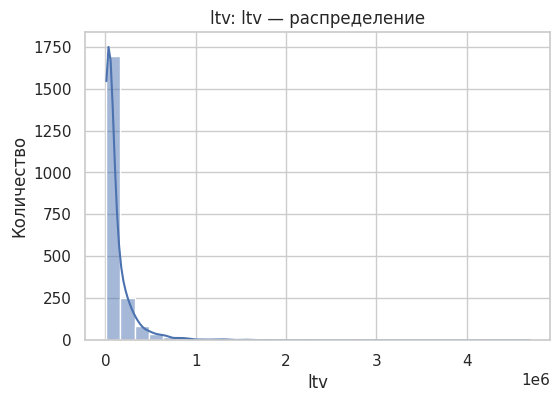

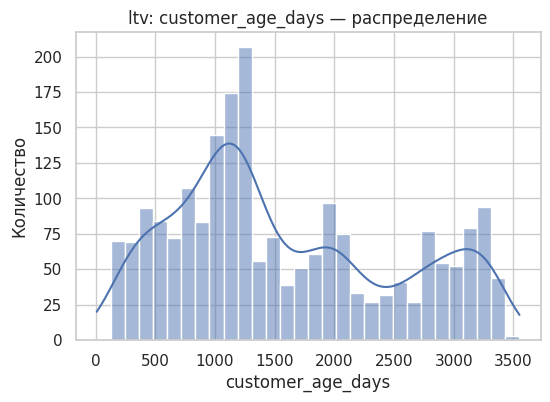

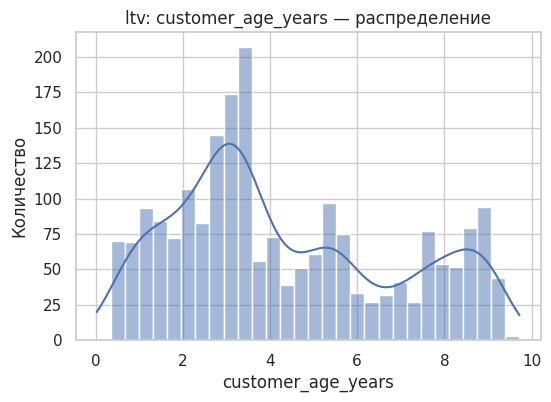

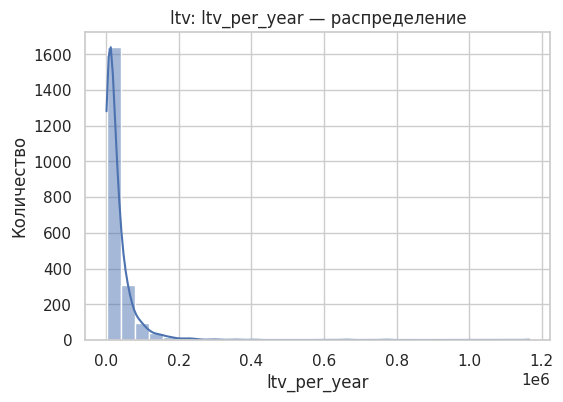

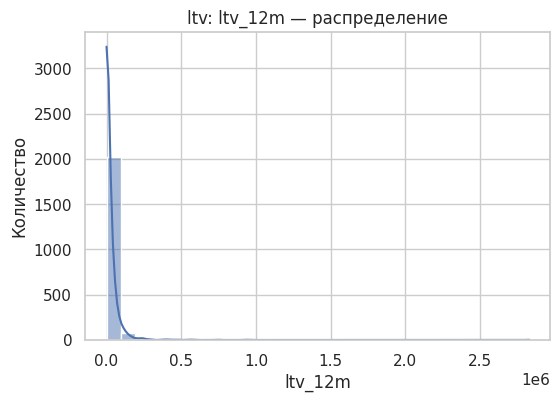

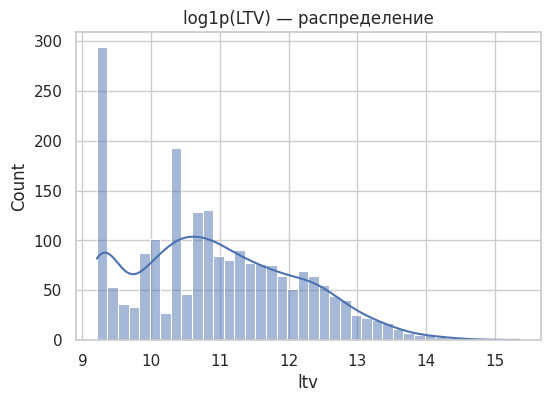

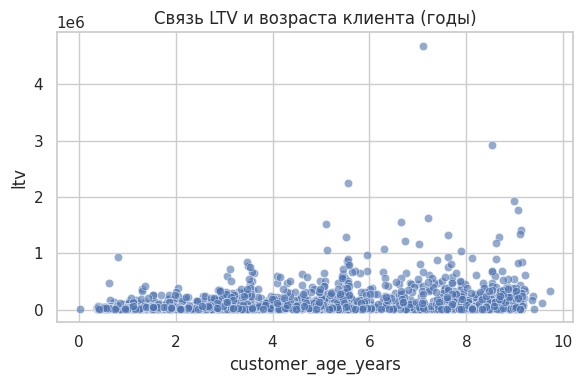

In [ ]:
# === 5. EDA: ltv ===

if "ltv" in dfs:
    ltv = dfs["ltv"].copy()
    quick_overview(ltv, "ltv")
    missing_values_report(ltv, "ltv")

    # Распределения ключевых метрик
    num_cols = [c for c in ["ltv", "customer_age_days", "customer_age_years", "ltv_per_year", "ltv_12m"] if c in ltv.columns]
    plot_numeric_distributions(ltv, num_cols, title_prefix="ltv: ")

    # Лог-распределение LTV (если много перекошено)
    if "ltv" in ltv.columns:
        ltv_nonzero = ltv["ltv"].replace(0, np.nan).dropna()
        plt.figure(figsize=(6, 4))
        sns.histplot(np.log1p(ltv_nonzero), bins=40, kde=True)
        plt.title("log1p(LTV) — распределение")
        plt.show()

    # Связь LTV и возраста клиента
    if set(["ltv", "customer_age_years"]).issubset(ltv.columns):
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=ltv, x="customer_age_years", y="ltv", alpha=0.6)
        plt.title("Связь LTV и возраста клиента (годы)")
        plt.tight_layout()
        plt.show()

else:
    print("ltv.csv не загружен")



Общий обзор: rfm

Размер: (2120, 7)

Первые строки:


,company_id,first_purchase,last_purchase,frequency,monetary,recency,customer_age_days
0,comp_0004b685d8d6,2019-05-03,2019-05-03,1,17000,1624,1624
1,comp_001eac7794df,2020-09-23,2023-09-03,27,270000,40,1115
2,comp_002f5166d79b,2020-11-28,2020-11-28,1,31000,1049,1049
3,comp_00323bea932a,2020-08-17,2020-08-17,1,16000,1152,1152
4,comp_003be29c3721,2022-09-24,2022-09-24,1,30000,384,384



Типы и количество ненулевых значений:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   company_id         2120 non-null   object        
 1   first_purchase     2120 non-null   datetime64[ns]
 2   last_purchase      2120 non-null   datetime64[ns]
 3   frequency          2120 non-null   int64         
 4   monetary           2120 non-null   int64         
 5   recency            2120 non-null   int64         
 6   customer_age_days  2120 non-null   int64         
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 116.1+ KB
None

Числовое описание:


,count,mean,std,min,25%,50%,75%,max
frequency,2120.0,5.327358,7.404857,1.0,1.0,3.0,6.00,83.0
monetary,2120.0,120180.188679,219250.901039,10000.0,22000.0,51000.0,132000.00,4691000.0
recency,2120.0,829.900943,808.831341,0.0,223.0,530.0,1170.75,3433.0
customer_age_days,2120.0,1579.978302,926.988743,10.0,898.0,1279.5,2247.75,3551.0



Категориальное описание:


,count,unique,top,freq
company_id,2120,2120,comp_ff67acb37c98,1



--- Пропуски в rfm ---
Пропусков нет.


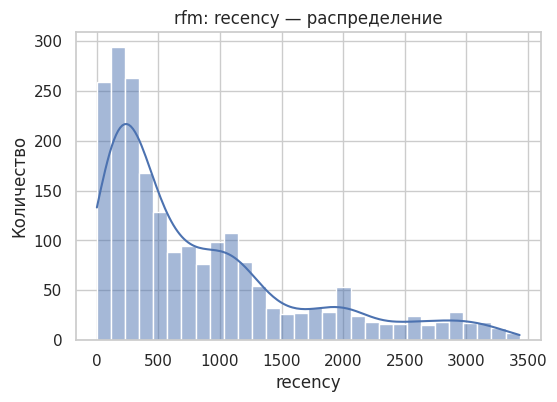

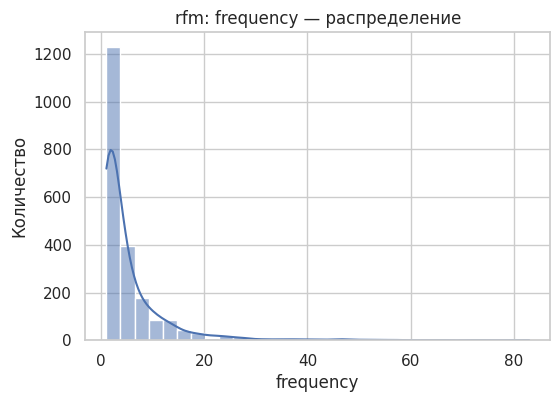

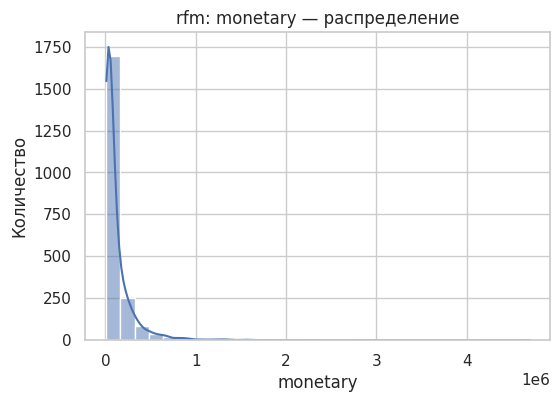

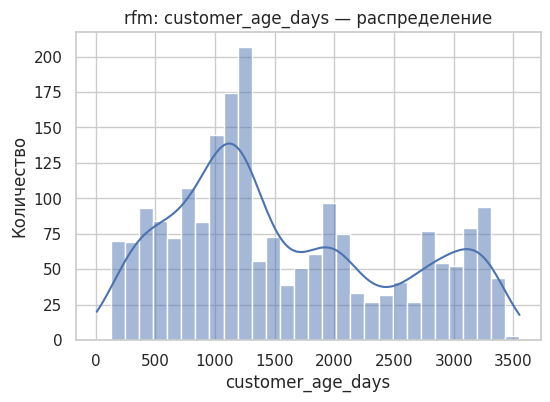

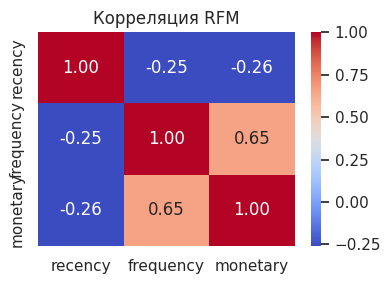

In [ ]:
# === 6. EDA: rfm ===

if "rfm" in dfs:
    rfm = dfs["rfm"].copy()
    quick_overview(rfm, "rfm")
    missing_values_report(rfm, "rfm")

    # Распределения R, F, M
    num_cols = [c for c in ["recency", "frequency", "monetary", "customer_age_days"] if c in rfm.columns]
    plot_numeric_distributions(rfm, num_cols, title_prefix="rfm: ")

    # Корреляция R/F/M
    rfm_corr_cols = [c for c in ["recency", "frequency", "monetary"] if c in rfm.columns]
    if len(rfm_corr_cols) >= 2:
        corr = rfm[rfm_corr_cols].corr()
        plt.figure(figsize=(4, 3))
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Корреляция RFM")
        plt.tight_layout()
        plt.show()

    # 3D-график R-F-M
    if set(["recency", "frequency", "monetary"]).issubset(rfm.columns):
        fig = px.scatter_3d(
            rfm,
            x="recency",
            y="frequency",
            z="monetary",
            title="3D RFM-зона клиентов",
            opacity=0.7
        )
        fig.show()

else:
    print("rfm.csv не загружен")



Общий обзор: basket

Размер: (2120, 29)

Первые строки:


,company_id,Enterprise Total-1000,Enterprise Total-150,Enterprise Total-2000,Enterprise Total-300,Enterprise Total-3000,Enterprise Total-500,Enterprise Total-5000,Enterprise-100,Enterprise-1000,Enterprise-150,Enterprise-2000,Enterprise-300,Enterprise-3000,Enterprise-50,Enterprise-500,Enterprise-5000,Академия,Вебинар 500 ( из платформы 2.0),Дополнительные услуги,Доски,МТС Линк. Команда,МТС Линк. Компания,МТС Линк. Корпорация,Общие Тарифы Webinar Enterprise,Расширения,Тарифы TMS,Тарифы Webinar СМБ,Чаты
0,comp_0004b685d8d6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,comp_001eac7794df,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,comp_002f5166d79b,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,comp_00323bea932a,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,comp_003be29c3721,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1



Типы и количество ненулевых значений:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   company_id                       2120 non-null   object
 1   Enterprise Total-1000            2120 non-null   int64 
 2   Enterprise Total-150             2120 non-null   int64 
 3   Enterprise Total-2000            2120 non-null   int64 
 4   Enterprise Total-300             2120 non-null   int64 
 5   Enterprise Total-3000            2120 non-null   int64 
 6   Enterprise Total-500             2120 non-null   int64 
 7   Enterprise Total-5000            2120 non-null   int64 
 8   Enterprise-100                   2120 non-null   int64 
 9   Enterprise-1000                  2120 non-null   int64 
 10  Enterprise-150                   2120 non-null   int64 
 11  Enterprise-2000                  2120 non-null   int64 


,count,mean,std,min,25%,50%,75%,max
Enterprise Total-1000,2120.0,0.024528,0.154719,0.0,0.0,0.0,0.0,1.0
Enterprise Total-150,2120.0,0.040566,0.197329,0.0,0.0,0.0,0.0,1.0
Enterprise Total-2000,2120.0,0.014151,0.118141,0.0,0.0,0.0,0.0,1.0
Enterprise Total-300,2120.0,0.031132,0.173716,0.0,0.0,0.0,0.0,1.0
Enterprise Total-3000,2120.0,0.008491,0.091774,0.0,0.0,0.0,0.0,1.0
Enterprise Total-500,2120.0,0.029245,0.168533,0.0,0.0,0.0,0.0,1.0
Enterprise Total-5000,2120.0,0.006604,0.081014,0.0,0.0,0.0,0.0,1.0
Enterprise-100,2120.0,0.108962,0.311665,0.0,0.0,0.0,0.0,1.0
Enterprise-1000,2120.0,0.030660,0.172436,0.0,0.0,0.0,0.0,1.0
Enterprise-150,2120.0,0.086792,0.281597,0.0,0.0,0.0,0.0,1.0



Категориальное описание:


,count,unique,top,freq
company_id,2120,2120,comp_ff67acb37c98,1



--- Пропуски в basket ---
Пропусков нет.


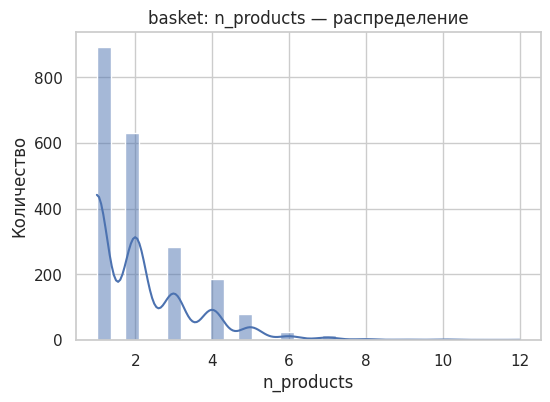


ТОП продуктов по числу клиентов, купивших продукт:


,0
Тарифы Webinar СМБ,1482
Расширения,1047
Enterprise-100,231
Enterprise-150,184
Доски,180
Enterprise-300,173
Enterprise-500,163
Чаты,152
Enterprise-50,138
МТС Линк. Компания,86


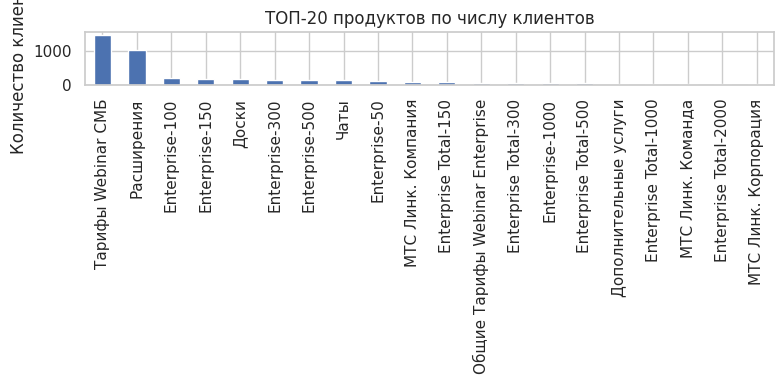

In [ ]:
# === 7. EDA: basket ===

if "basket" in dfs:
    basket = dfs["basket"].copy()
    quick_overview(basket, "basket")
    missing_values_report(basket, "basket")

    # Предполагаем, что кроме company_id все остальные столбцы — продукты 0/1
    product_cols = [c for c in basket.columns if c != "company_id"]

    # Количество купленных разных продуктов на клиента
    basket["n_products"] = basket[product_cols].sum(axis=1)
    plot_numeric_distributions(basket, ["n_products"], title_prefix="basket: ")

    # ТОП продуктов по числу клиентов
    product_counts = basket[product_cols].sum().sort_values(ascending=False)
    print("\nТОП продуктов по числу клиентов, купивших продукт:")
    display(product_counts.head(20))

    plt.figure(figsize=(8, 4))
    product_counts.head(20).plot(kind="bar")
    plt.title("ТОП-20 продуктов по числу клиентов")
    plt.ylabel("Количество клиентов")
    plt.tight_layout()
    plt.show()

else:
    print("basket.csv не загружен")



Общий обзор: rfm-features

Размер: (2120, 12)

Первые строки:


,company_id,first_purchase,last_purchase,frequency,monetary,recency,customer_age_days,n_products,Возврат,Новая,Продление,Расширение
0,comp_0004b685d8d6,2019-05-03,2019-05-03,1,17000,1624,1624,1,0.0,1.0,0.0,0.0
1,comp_001eac7794df,2020-09-23,2023-09-03,27,270000,40,1115,1,0.0,1.0,11.0,15.0
2,comp_002f5166d79b,2020-11-28,2020-11-28,1,31000,1049,1049,2,0.0,3.0,0.0,0.0
3,comp_00323bea932a,2020-08-17,2020-08-17,1,16000,1152,1152,1,0.0,1.0,0.0,0.0
4,comp_003be29c3721,2022-09-24,2022-09-24,1,30000,384,384,3,0.0,3.0,0.0,0.0



Типы и количество ненулевых значений:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   company_id         2120 non-null   object 
 1   first_purchase     2120 non-null   object 
 2   last_purchase      2120 non-null   object 
 3   frequency          2120 non-null   int64  
 4   monetary           2120 non-null   int64  
 5   recency            2120 non-null   int64  
 6   customer_age_days  2120 non-null   int64  
 7   n_products         2120 non-null   int64  
 8   Возврат            2039 non-null   float64
 9   Новая              2039 non-null   float64
 10  Продление          2039 non-null   float64
 11  Расширение         2039 non-null   float64
dtypes: float64(4), int64(5), object(3)
memory usage: 198.9+ KB
None

Числовое описание:


,count,mean,std,min,25%,50%,75%,max
frequency,2120.0,5.327358,7.404857,1.0,1.0,3.0,6.00,83.0
monetary,2120.0,120180.188679,219250.901039,10000.0,22000.0,51000.0,132000.00,4691000.0
recency,2120.0,829.900943,808.831341,0.0,223.0,530.0,1170.75,3433.0
customer_age_days,2120.0,1579.978302,926.988743,10.0,898.0,1279.5,2247.75,3551.0
n_products,2120.0,2.117453,1.371137,1.0,1.0,2.0,3.00,12.0
Возврат,2039.0,0.467876,1.492810,0.0,0.0,0.0,0.00,36.0
Новая,2039.0,1.578225,1.648932,0.0,1.0,1.0,2.00,46.0
Продление,2039.0,4.058852,7.689859,0.0,0.0,1.0,5.00,103.0
Расширение,2039.0,0.803825,2.421235,0.0,0.0,0.0,0.00,27.0



Категориальное описание:


,count,unique,top,freq
company_id,2120,2120,comp_ff67acb37c98,1
first_purchase,2120,1224,2023-03-31,7
last_purchase,2120,1145,2023-03-31,17



--- Пропуски в rfm-features ---


,n_missing,pct_missing
Возврат,81,3.82
Новая,81,3.82
Продление,81,3.82
Расширение,81,3.82


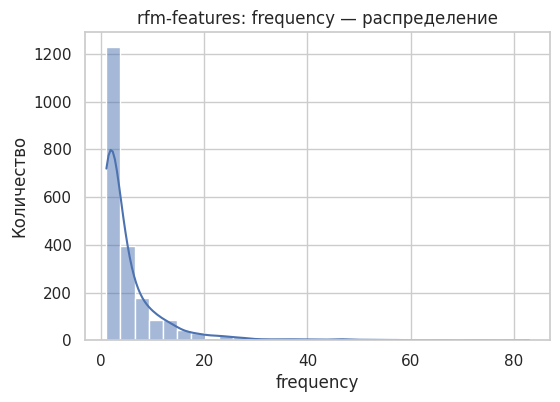

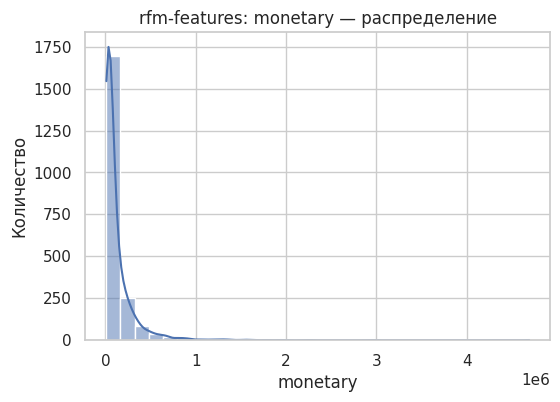

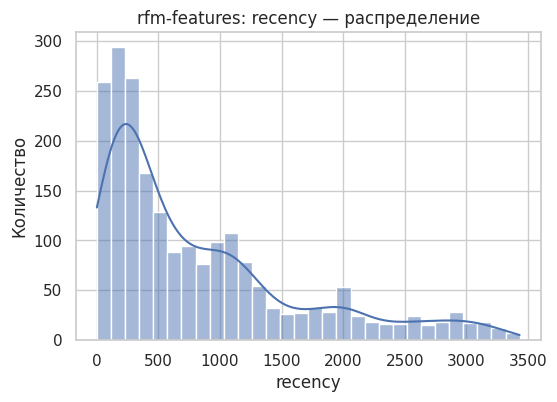

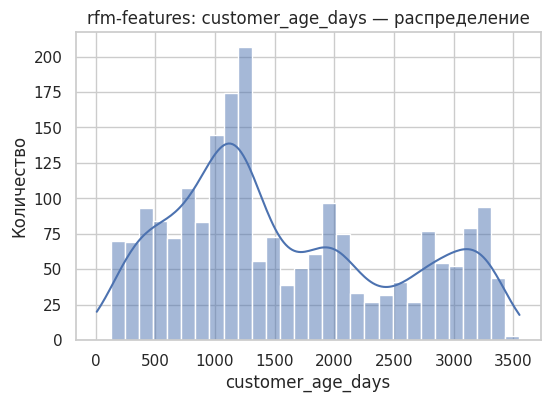

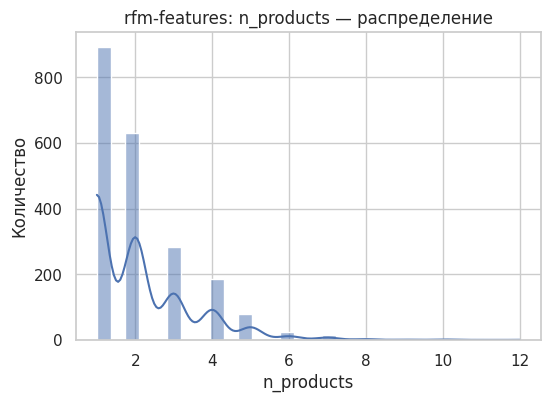

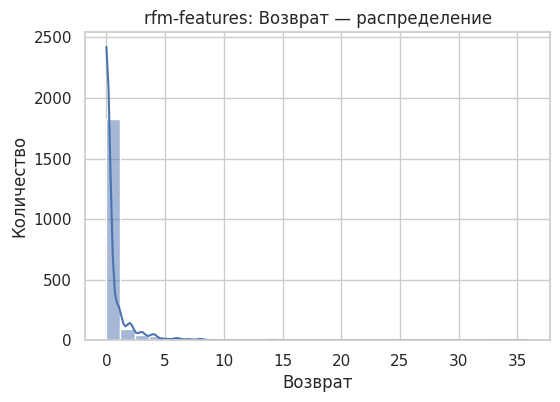

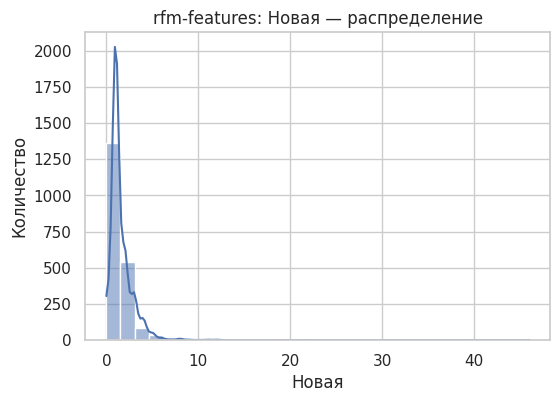

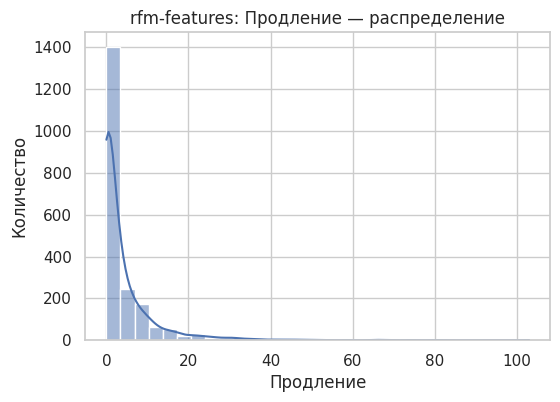

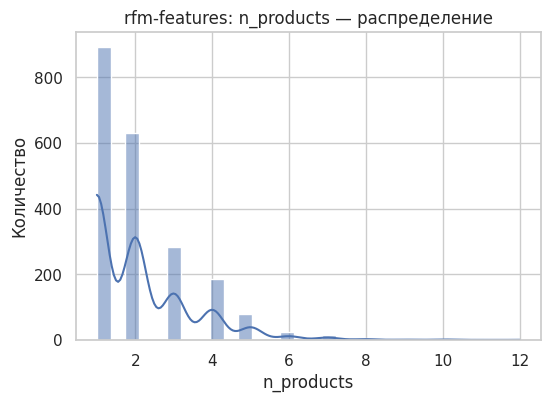

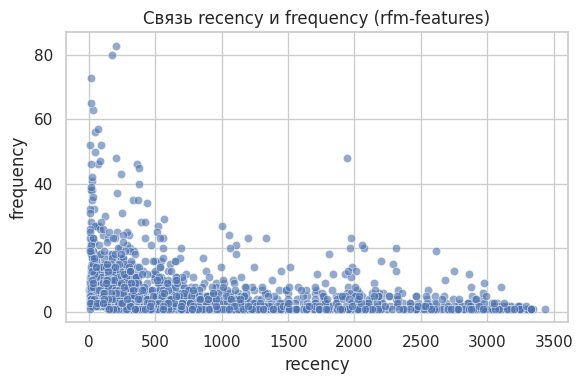

In [ ]:
# === 8. EDA: rfm-features ===

if "rfm_features" in dfs:
    rfm_f = dfs["rfm_features"].copy()
    quick_overview(rfm_f, "rfm-features")
    missing_values_report(rfm_f, "rfm-features")

    # Числовые распределения
    num_cols = rfm_f.select_dtypes(include="number").columns.tolist()
    # чтобы не строить сразу слишком много, ограничимся 8
    plot_numeric_distributions(rfm_f, num_cols[:8], title_prefix="rfm-features: ")

    # Если есть n_products
    if "n_products" in rfm_f.columns:
        plot_numeric_distributions(rfm_f, ["n_products"], title_prefix="rfm-features: ")

    # Простая визуализация пары признаков
    base_pair = [c for c in ["recency", "frequency", "monetary", "n_products"] if c in rfm_f.columns][:2]
    if len(base_pair) == 2:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=rfm_f, x=base_pair[0], y=base_pair[1], alpha=0.6)
        plt.title(f"Связь {base_pair[0]} и {base_pair[1]} (rfm-features)")
        plt.tight_layout()
        plt.show()

else:
    print("rfm-features.csv не загружен")


In [ ]:
# === 9. Интеграция по company_id ===

companies = dfs.get("companies")
rfm = dfs.get("rfm")
ltv = dfs.get("ltv")
rfm_f = dfs.get("rfm_features")

df_all = None

if companies is not None and "company_id" in companies.columns:
    df_all = companies.copy()
    print("Базовый df_all: companies, shape:", df_all.shape)

    if rfm is not None and "company_id" in rfm.columns:
        df_all = df_all.merge(rfm, on="company_id", how="left", suffixes=("", "_rfm"))
        print("После join с rfm:", df_all.shape)

    if ltv is not None and "company_id" in ltv.columns:
        cols_ltv = ["company_id", "ltv", "ltv_per_year", "ltv_12m"]
        cols_ltv = [c for c in cols_ltv if c in ltv.columns]
        df_all = df_all.merge(ltv[cols_ltv], on="company_id", how="left")
        print("После join с ltv:", df_all.shape)

    if rfm_f is not None and "company_id" in rfm_f.columns:
        drop_cols = [c for c in ["recency", "frequency", "monetary"] if c in rfm_f.columns]
        df_all = df_all.merge(
            rfm_f.drop(columns=drop_cols),
            on="company_id",
            how="left",
            suffixes=("", "_rfmf")
        )
        print("После join с rfm-features:", df_all.shape)

    missing_values_report(df_all, "df_all")

    # пример: средний LTV по сегментам, если сегменты есть
    if {"segment", "ltv"}.issubset(df_all.columns):
        seg_ltv = df_all.groupby("segment")["ltv"].agg(["count", "mean", "median"]).sort_values("mean", ascending=False)
        print("\nLTV по сегментам:")
        display(seg_ltv)

        fig = px.bar(seg_ltv.reset_index(), x="segment", y="mean", title="Средний LTV по сегментам")
        fig.show()

else:
    print("Невозможно собрать df_all: нет companies.csv или в нём нет company_id")


Базовый df_all: companies, shape: (2120, 7)
После join с rfm: (2120, 13)
После join с ltv: (2120, 16)
После join с rfm-features: (2120, 24)

--- Пропуски в df_all ---


,n_missing,pct_missing
Возврат,81,3.82
Новая,81,3.82
Продление,81,3.82
Расширение,81,3.82



LTV по сегментам:


,count,mean,median
segment,,,
Commercial_Scale,78,345217.948718,91500.0
Business_Scale,134,161805.970149,76500.0
Public_Large,541,160345.656192,74000.0
Large_business,231,125532.467532,75000.0
Small_business,483,86925.465839,44000.0
Micro,122,80467.213115,35500.0
Medium_business,214,80308.411215,42000.0
Public_Small_Medium,304,68608.552632,30500.0
Undefined,8,45000.000000,28500.0


In [ ]:
# === 10. Экспорт df_all (опционально) ===

if df_all is not None:
    out_path = DATA_DIR / "df_all_eda_export.csv"
    df_all.to_csv(out_path, index=False)
    print("Сохранено:", out_path)
else:
    print("df_all не создан")


Сохранено: /content/df_all_eda_export.csv


In [ ]:
# Статистика и тесты
from scipy import stats
import numpy as np
import pandas as pd


In [ ]:
# === H1: доля "Продление" по клиенту ===

revenue = dfs.get("revenue")
ltv = dfs.get("ltv")
rfm = dfs.get("rfm")

if revenue is None or ltv is None:
    print("❗ Нужны revenue.csv и ltv.csv")
else:
    h1 = revenue.copy()

    # фильтруем только строки, где sale_type не пустой
    if "sale_type" not in h1.columns:
        raise ValueError("В revenue нет столбца 'sale_type' — гипотезу 1 так не проверить")

    # агрегаты по клиенту
    h1_agg = (
        h1
        .groupby("company_id")
        .agg(
            n_rows=("sale_id", "count"),
            n_sales=("sale_id", "nunique"),
            n_renewals=("sale_type", lambda s: (s == "Продление").sum()),
        )
        .reset_index()
    )

    h1_agg["renewal_share"] = h1_agg["n_renewals"] / h1_agg["n_sales"].replace(0, np.nan)

    # бинарный флаг: есть ли вообще продления
    h1_agg["has_renewals"] = h1_agg["n_renewals"] > 0

    # join с LTV
    h1_df = h1_agg.merge(
        ltv[["company_id", "ltv", "ltv_12m"]] if "ltv_12m" in ltv.columns else ltv[["company_id", "ltv"]],
        on="company_id",
        how="left"
    )

    # добавим recency / frequency, если есть rfm
    if rfm is not None:
        cols_rfm = ["company_id"]
        for c in ["recency", "frequency", "monetary"]:
            if c in rfm.columns:
                cols_rfm.append(c)
        h1_df = h1_df.merge(rfm[cols_rfm], on="company_id", how="left")

    print("Размер таблицы для H1:", h1_df.shape)
    display(h1_df.head())


Размер таблицы для H1: (2120, 11)


,company_id,n_rows,n_sales,n_renewals,renewal_share,has_renewals,ltv,ltv_12m,recency,frequency,monetary
0,comp_0004b685d8d6,1,1,0,0.000000,False,17000,0,1624,1,17000
1,comp_001eac7794df,27,27,11,0.407407,True,270000,80000,40,27,270000
2,comp_002f5166d79b,3,1,0,0.000000,False,31000,0,1049,1,31000
3,comp_00323bea932a,1,1,0,0.000000,False,16000,0,1152,1,16000
4,comp_003be29c3721,3,1,0,0.000000,False,30000,0,384,1,30000


In [ ]:
# === H1: сравнение групп по доле "Продление" ===

h1_work = h1_df.dropna(subset=["renewal_share", "ltv"]).copy()

median_share = h1_work["renewal_share"].median()
print("Медиана доли продлений:", median_share)

h1_work["renewal_group"] = np.where(
    h1_work["renewal_share"] > median_share,
    "high_renewal",
    "low_renewal",
)

group_stats = (
    h1_work
    .groupby("renewal_group")["ltv"]
    .agg(["count", "mean", "median"])
)
print("\nLTV по группам (high vs low renewal_share):")
display(group_stats)

high = h1_work.loc[h1_work["renewal_group"] == "high_renewal", "ltv"].dropna()
low = h1_work.loc[h1_work["renewal_group"] == "low_renewal", "ltv"].dropna()

t_stat, p_val = stats.ttest_ind(high, low, equal_var=False)
print(f"\nT-test high vs low renewal_share по LTV:")
print("t =", t_stat, "  p-value =", p_val)

# Cohen's d
def cohens_d(a, b):
    a = np.array(a)
    b = np.array(b)
    na, nb = len(a), len(b)
    var_pooled = ((na - 1) * a.var(ddof=1) + (nb - 1) * b.var(ddof=1)) / (na + nb - 2)
    return (a.mean() - b.mean()) / np.sqrt(var_pooled)

d = cohens_d(high, low)
print("Cohen's d =", d)


Медиана доли продлений: 0.3333333333333333

LTV по группам (high vs low renewal_share):


,count,mean,median
renewal_group,,,
high_renewal,990,199901.010101,115000.0
low_renewal,1130,50336.283186,29000.0



T-test high vs low renewal_share по LTV:
t = 15.771833862698903   p-value = 7.006249493218609e-51
Cohen's d = 0.7253215819988257


In [ ]:
# === H1: отток через recency (если есть) ===

if "recency" in h1_work.columns:
    h1_work["is_churned"] = h1_work["recency"] > 365

    churn_table = (
        h1_work
        .groupby("renewal_group")["is_churned"]
        .agg(["mean", "count"])
        .rename(columns={"mean": "churn_rate"})
    )
    print("\nCредний 'отток' (recency>365) по группам renewal_share:")
    display(churn_table)

    # χ²-тест на независимость
    contingency = pd.crosstab(h1_work["renewal_group"], h1_work["is_churned"])
    print("\nКонтингентная таблица high/low renewal vs churn:")
    display(contingency)

    chi2, p_chi, dof, expected = stats.chi2_contingency(contingency)
    print("Chi2 =", chi2, " p-value =", p_chi)
else:
    print("В rfm нет recency — отток через recency посчитать нельзя.")



Cредний 'отток' (recency>365) по группам renewal_share:


,churn_rate,count
renewal_group,,
high_renewal,0.432323,990
low_renewal,0.734513,1130



Контингентная таблица high/low renewal vs churn:


is_churned,False,True
renewal_group,,
high_renewal,562,428
low_renewal,300,830


Chi2 = 198.46965632404624  p-value = 4.50602301216608e-45


Типы колонок в H2:


,0
company_size,float64
ltv,int64


Размер данных для H2: (2101, 10)


,Unnamed: 0,company_id,sector,segment,industry,company_size,revenue,ltv,ltv_12m,size_group
0,0,comp_df0a0c0bd619,sec_07f5ebaa60c6,Public_Small_Medium,ind_d2091f85a3a3,50.0,105402,11000,0,small_medium
1,1,comp_1e8c0f0ab24c,sec_9d370c38febe,Small_business,ind_6be1923b9422,28.0,107905,228000,26000,small_medium
2,2,comp_7b5d176f09b3,sec_5fb21c55bb11,Business_Scale,ind_5fb21c55bb11,5000.0,248435,36000,0,large_500plus
3,3,comp_d07c716a7b02,sec_1bc3700e30b8,Public_Small_Medium,ind_11d103ed33f7,100.0,111632,13000,0,small_medium
4,4,comp_ca8821847ff0,sec_1bc3700e30b8,Public_Large,ind_5ffda163ccd7,50.0,106819,33000,0,small_medium


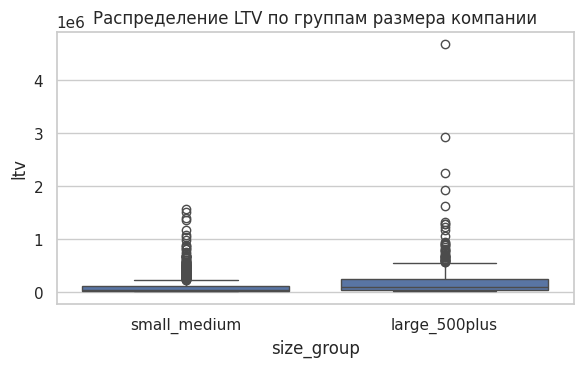


LTV по группам размера компании:


,count,mean,median
size_group,,,
large_500plus,453,207024.282561,90000.0
small_medium,1648,95297.330097,45000.0



T-test large_500plus vs small_medium по LTV:
t = 6.406452316882256   p-value = 3.4858122530291465e-10
Cohen's d = 0.5269289070484148


In [ ]:
# === H2: крупные компании и LTV ===

companies = dfs.get("companies")
ltv = dfs.get("ltv")

if companies is None or ltv is None:
    print("❗ Нужны companies.csv и ltv.csv")
else:

    h2 = companies.copy()

    if "company_size" not in h2.columns:
        raise ValueError("В companies нет 'company_size' — гипотезу 2 так не проверить")

    import numpy as np
    from scipy import stats

    # -----------------------------------------------------------
    # 1. Чистим и приводим company_size и LTV к числам
    # -----------------------------------------------------------

    missing_tokens = ["нет данных", "НЕТ ДАННЫХ", "-", "n/a", "NA", "NaN", ""]

    # clean company_size
    h2["company_size"] = h2["company_size"].replace(missing_tokens, np.nan)
    h2["company_size"] = pd.to_numeric(h2["company_size"], errors="coerce")

    # clean LTV
    ltv_clean = ltv.copy()
    ltv_clean["ltv"] = pd.to_numeric(ltv_clean["ltv"], errors="coerce")
    if "ltv_12m" in ltv_clean.columns:
        ltv_clean["ltv_12m"] = pd.to_numeric(ltv_clean["ltv_12m"], errors="coerce")

    # -----------------------------------------------------------
    # 2. Соединяем companies + LTV
    # -----------------------------------------------------------

    cols_ltv = ["company_id", "ltv"]
    if "ltv_12m" in ltv_clean.columns:
        cols_ltv.append("ltv_12m")

    h2 = h2.merge(ltv_clean[cols_ltv], on="company_id", how="left")

    # -----------------------------------------------------------
    # 3. Убираем строки без company_size или LTV
    # -----------------------------------------------------------

    h2 = h2.dropna(subset=["company_size", "ltv"]).copy()

    print("Типы колонок в H2:")
    display(h2[["company_size", "ltv"]].dtypes)

    # -----------------------------------------------------------
    # 4. Делим на группы: крупные > 500 сотрудников
    # -----------------------------------------------------------

    h2["size_group"] = np.where(h2["company_size"] > 500, "large_500plus", "small_medium")

    print("Размер данных для H2:", h2.shape)
    display(h2.head())

    # -----------------------------------------------------------
    # 5. Визуализация распределения LTV
    # -----------------------------------------------------------

    plt.figure(figsize=(6, 4))
    sns.boxplot(data=h2, x="size_group", y="ltv")
    plt.title("Распределение LTV по группам размера компании")
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------------
    # 6. Статистика по группам
    # -----------------------------------------------------------

    group_stats_h2 = h2.groupby("size_group")["ltv"].agg(["count", "mean", "median"])
    print("\nLTV по группам размера компании:")
    display(group_stats_h2)

    large = h2.loc[h2["size_group"] == "large_500plus", "ltv"].dropna()
    small = h2.loc[h2["size_group"] == "small_medium", "ltv"].dropna()

    t_stat2, p_val2 = stats.ttest_ind(large, small, equal_var=False)
    print("\nT-test large_500plus vs small_medium по LTV:")
    print("t =", t_stat2, "  p-value =", p_val2)

    # -----------------------------------------------------------
    # 7. Cohen's d — размер эффекта
    # -----------------------------------------------------------

    def cohens_d(a, b):
        a = np.array(a)
        b = np.array(b)
        na, nb = len(a), len(b)
        var_pooled = ((na - 1) * a.var(ddof=1) + (nb - 1) * b.var(ddof=1)) / (na + nb - 2)
        return (a.mean() - b.mean()) / np.sqrt(var_pooled)

    d2 = cohens_d(large, small)
    print("Cohen's d =", d2)


In [ ]:
# === H3: флаг коллаборативных продуктов по basket ===

basket = dfs.get("basket")
ltv = dfs.get("ltv")
rfm = dfs.get("rfm")

if basket is None or ltv is None:
    print("❗ Нужны basket.csv и ltv.csv")
else:
    b = basket.copy()

    # ищем столбцы с коллабортивными продуктами по подстрокам
    collab_keywords = ["доски", "доска", "чаты", "чат", "линк", "link", "МТС Линк", "MTS Link"]
    product_cols = [c for c in b.columns if c != "company_id"]

    collab_cols = [
        c for c in product_cols
        if any(kw.lower() in c.lower() for kw in collab_keywords)
    ]

    print("Коллаборативные столбцы найдены:", collab_cols)

    if not collab_cols:
        print("⚠️ Не нашли столбцов, содержащих ключевые слова для коллаборативных продуктов.")
    else:
        # флаг: клиент использует хотя бы один из коллаборативных продуктов
        b["has_collab"] = (b[collab_cols] > 0).any(axis=1)

        # объединяем с LTV и RFM
        h3 = b.merge(ltv[["company_id", "ltv", "ltv_12m"]] if "ltv_12m" in ltv.columns else ltv[["company_id", "ltv"]],
                     on="company_id",
                     how="left")

        if rfm is not None:
            cols_rfm = ["company_id"]
            for c in ["recency", "frequency", "monetary"]:
                if c in rfm.columns:
                    cols_rfm.append(c)
            h3 = h3.merge(rfm[cols_rfm], on="company_id", how="left")

        print("Размер данных для H3:", h3.shape)
        display(h3.head())


Коллаборативные столбцы найдены: ['Доски', 'МТС Линк. Команда', 'МТС Линк. Компания', 'МТС Линк. Корпорация', 'Чаты']
Размер данных для H3: (2120, 35)


,company_id,Enterprise Total-1000,Enterprise Total-150,Enterprise Total-2000,Enterprise Total-300,Enterprise Total-3000,Enterprise Total-500,Enterprise Total-5000,Enterprise-100,Enterprise-1000,Enterprise-150,Enterprise-2000,Enterprise-300,Enterprise-3000,Enterprise-50,Enterprise-500,Enterprise-5000,Академия,Вебинар 500 ( из платформы 2.0),Дополнительные услуги,Доски,МТС Линк. Команда,МТС Линк. Компания,МТС Линк. Корпорация,Общие Тарифы Webinar Enterprise,Расширения,Тарифы TMS,Тарифы Webinar СМБ,Чаты,has_collab,ltv,ltv_12m,recency,frequency,monetary
0,comp_0004b685d8d6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,17000,0,1624,1,17000
1,comp_001eac7794df,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,False,270000,80000,40,27,270000
2,comp_002f5166d79b,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,False,31000,0,1049,1,31000
3,comp_00323bea932a,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,16000,0,1152,1,16000
4,comp_003be29c3721,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,True,30000,0,384,1,30000


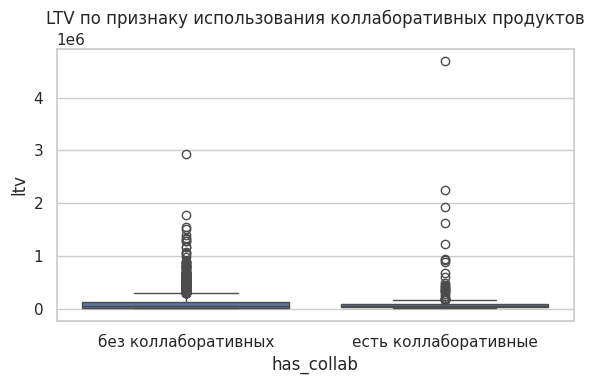


LTV по группам has_collab:


,count,mean,median
has_collab,,,
False,1933,116443.869633,51000.0
True,187,158802.139037,51000.0



T-test has_collab=True vs False по LTV:
t = 1.303573109126906   p-value = 0.19393742688642737
Cohen's d = 0.19344052529257072

'Отток' по группам has_collab:


,churn_rate,count
has_collab,,
False,0.623383,1933
True,0.283422,187



Контингентная таблица has_collab vs churn:


is_churned,False,True
has_collab,,
False,728,1205
True,134,53


Chi2 = 80.27022185721084  p-value = 3.2655338993004967e-19


In [ ]:
# === H3: сравнение LTV и удержания ===

if "has_collab" in h3.columns:
    h3_work = h3.dropna(subset=["ltv"]).copy()

    plt.figure(figsize=(6, 4))
    sns.boxplot(data=h3_work, x="has_collab", y="ltv")
    plt.title("LTV по признаку использования коллаборативных продуктов")
    plt.xticks([0, 1], ["без коллаборативных", "есть коллаборативные"])
    plt.tight_layout()
    plt.show()

    group_stats_h3 = h3_work.groupby("has_collab")["ltv"].agg(["count", "mean", "median"])
    print("\nLTV по группам has_collab:")
    display(group_stats_h3)

    collab = h3_work.loc[h3_work["has_collab"], "ltv"].dropna()
    no_collab = h3_work.loc[~h3_work["has_collab"], "ltv"].dropna()

    t_stat3, p_val3 = stats.ttest_ind(collab, no_collab, equal_var=False)
    print("\nT-test has_collab=True vs False по LTV:")
    print("t =", t_stat3, "  p-value =", p_val3)

    d3 = cohens_d(collab, no_collab)
    print("Cohen's d =", d3)

    # Прокси-удержание через recency (как и в H1)
    if "recency" in h3_work.columns:
        h3_work["is_churned"] = h3_work["recency"] > 365

        churn_stats_h3 = h3_work.groupby("has_collab")["is_churned"].agg(["mean", "count"])
        churn_stats_h3.rename(columns={"mean": "churn_rate"}, inplace=True)
        print("\n'Отток' по группам has_collab:")
        display(churn_stats_h3)

        cont_h3 = pd.crosstab(h3_work["has_collab"], h3_work["is_churned"])
        print("\nКонтингентная таблица has_collab vs churn:")
        display(cont_h3)

        chi2_3, p_chi3, dof3, exp3 = stats.chi2_contingency(cont_h3)
        print("Chi2 =", chi2_3, " p-value =", p_chi3)
else:
    print("has_collab не рассчитан — возможно, не нашлись нужные столбцы в basket.")


In [ ]:
# === H3: ассоциативные правила (Apriori) ===

!pip install mlxtend -q

from mlxtend.frequent_patterns import apriori, association_rules

basket = dfs.get("basket")
if basket is None:
    print("Нет basket.csv")
else:
    b = basket.copy()
    product_cols = [c for c in b.columns if c != "company_id"]

    # в Apriori нужны булевы флаги
    b_bool = b[product_cols] > 0

    freq_items = apriori(b_bool, min_support=0.05, use_colnames=True)
    print("Количество частых наборов:", len(freq_items))

    rules = association_rules(freq_items, metric="lift", min_threshold=1.0)

    # правила, где в последствии есть коллаборативный продукт
    collab_pattern = "|".join([kw for kw in ["Доски", "Чаты", "Линк", "Link"]])
    rules_collab = rules[
        rules["consequents"].astype(str).str.contains(collab_pattern, case=False, regex=True)
    ].sort_values("lift", ascending=False)

    print("\nПравила с коллаборативными продуктами в последствии (top-20 по lift):")
    display(rules_collab.head(20))


Количество частых наборов: 15

Правила с коллаборативными продуктами в последствии (top-20 по lift):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
8,(Чаты),(Доски),0.071698,0.084906,0.069811,0.973684,11.467836,1.0,0.063724,34.773585,0.983300,0.804348,0.971243,0.897953
9,(Доски),(Чаты),0.084906,0.071698,0.069811,0.822222,11.467836,1.0,0.063724,5.221698,0.997492,0.804348,0.808491,0.897953


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

In [ ]:
# === SAVE ALL RESULTS ===

if 'h1_df' in globals():
    h1_df.to_csv("/content/h1_renewals_metrics.csv", index=False)
    print("Saved: h1_renewals_metrics.csv")

if 'h2' in globals():
    h2.to_csv("/content/h2_size_ltv.csv", index=False)
    print("Saved: h2_size_ltv.csv")

if 'h3' in globals():
    h3.to_csv("/content/h3_collab_ltv_retention.csv", index=False)
    print("Saved: h3_collab_ltv_retention.csv")

if 'rules_collab' in globals():
    rules_collab.to_csv("/content/h3_collab_rules.csv", index=False)
    print("Saved: h3_collab_rules.csv")


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

Saved: h1_renewals_metrics.csv
Saved: h2_size_ltv.csv
Saved: h3_collab_ltv_retention.csv
Saved: h3_collab_rules.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v